In [1]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable
import time
import collections
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor, tensor
import pandas as pd
import openml

from optuna_kfoldCV import evaluate_dataset_with_model, run_all_openML_with_model
from regression_param_specs import evaluate_Ridge, evaluate_XGBoostRegressor

np.set_printoptions(precision=3, threshold=5) # Print options

# OpenML code

In [ ]:
# Fetch the collection with ID 353
collection = openml.study.get_suite(353)
dataset_ids = collection.data
metadata_list = []

# Fetch and process each dataset
for i, dataset_id in enumerate(dataset_ids):
    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        target=dataset.default_target_attribute
    )

    #count missing values in X
    missing_values_count = X.isnull().sum().sum()
    print(f"Missing values in X: {missing_values_count}")

    X = np.array(X)
    y = np.array(y)[..., None]
    print(X.shape)
    print(y.shape)
    
    # Determine if the dataset has categorical features
    has_categorical = any(categorical_indicator)
    
    # Extract the required metadata
    metadata = {
        'dataset_id': dataset.id,
        'name': dataset.name,
        'n_obs': int(dataset.qualities['NumberOfInstances']),
        'n_features': int(dataset.qualities['NumberOfFeatures']),
        '%_unique_y': len(np.unique(y))/len(y),
        'n_unique_y': len(np.unique(y)),
        'has_categorical': has_categorical,
        'n_missing_values': missing_values_count,
    }
    
    metadata_list.append(metadata)
    print(f" {i+1}/{len(dataset_ids)} Processed dataset {dataset.id}: {dataset.name}")

# Create a DataFrame from the metadata list
df_metadata = pd.DataFrame(metadata_list).sort_values('%_unique_y', ascending=False).set_index("dataset_id").sort_index()
df_metadata.sort_values('%_unique_y', ascending=True)

# Display the metadata DataFrame
df_metadata.loc[44962, "has_categorical"] = True
df_metadata

In [2]:
from optuna_kfoldCV import np_load_openml_dataset, openML_reg_ids
import numpy as np

for idx, id in enumerate(openML_reg_ids):
    X,y = np_load_openml_dataset(id, "regression")
    print("idx", idx, "id", id, "X", X.shape, "y", y.shape, np.isnan(X).sum(), np.isnan(y).sum())

# for id in df_metadata.index:
#     X,y = np_load_openml_dataset(id, "regression")
#     print("id", id, "X", X.shape, "y", y.shape, np.isnan(X).sum(), np.isnan(y).sum())


## TODO TODO TODO NEXT: investigate nans, and "Mean of empty slice". also look at less than 200 features and check performance on reg

idx 0 id 41021 X (1232, 72) y (1232, 1) 0 0
idx 1 id 44956 X (4177, 10) y (4177, 1) 0 0
idx 2 id 44957 X (1503, 5) y (1503, 1) 0 0
idx 3 id 44958 X (2043, 16) y (2043, 1) 0 0
idx 4 id 44959 X (1030, 8) y (1030, 1) 0 0
idx 5 id 44960 X (768, 8) y (768, 1) 0 0
idx 6 id 44962 X (517, 29) y (517, 1) 0 0
idx 7 id 44963 X (5000, 9) y (5000, 1) 0 0
idx 8 id 44964 X (5000, 81) y (5000, 1) 0 0
idx 9 id 44965 X (1059, 116) y (1059, 1) 0 0
idx 10 id 44966 X (1066, 29) y (1066, 1) 0 0
idx 11 id 44967 X (649, 56) y (649, 1) 0 0
idx 12 id 44969 X (5000, 14) y (5000, 1) 0 0
idx 13 id 44970 X (908, 6) y (908, 1) 0 0
idx 14 id 44971 X (4898, 11) y (4898, 1) 0 0
idx 15 id 44972 X (1599, 11) y (1599, 1) 0 0
idx 16 id 44973 X (5000, 12) y (5000, 1) 0 0
idx 17 id 44974 X (5000, 24) y (5000, 1) 0 0
idx 18 id 44975 X (5000, 48) y (5000, 1) 0 0
idx 19 id 44976 X (5000, 21) y (5000, 1) 0 0
idx 20 id 44977 X (5000, 8) y (5000, 1) 0 0
idx 21 id 44978 X (5000, 21) y (5000, 1) 0 0
idx 22 id 44979 X (5000, 26) y (5

# Run experiments (just for testing)

In [4]:
# !python regression_param_specs.py \
#     --models End2End \
#     --dataset_indices 0 \
#     --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
#     --n_optuna_trials 2 \
#     --device cuda \
#     --k_folds 2 \
#     --cv_seed 42

In [4]:
!python regression_param_specs.py \
    --models Ridge \
    --dataset_indices 10 \
    --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
    --n_optuna_trials 2 \
    --device cuda \
    --k_folds 2 \
    --cv_seed 42

[I 2025-01-13 17:04:40,307] A new study created in memory with name: no-name-82933992-5a54-4816-a290-ee82a1d077d8
[I 2025-01-13 17:04:40,377] Trial 0 finished with value: 0.69959357380867 and parameters: {'l2_reg': 0.0074593432857265485}. Best is trial 0 with value: 0.69959357380867.
[I 2025-01-13 17:04:40,380] Trial 1 finished with value: 0.6974271237850189 and parameters: {'l2_reg': 5.669849511478847}. Best is trial 1 with value: 0.6974271237850189.
[I 2025-01-13 17:04:40,383] A new study created in memory with name: no-name-d3b0f327-ac67-4aa7-b7e5-830b10cf6ce1
[I 2025-01-13 17:04:40,385] Trial 0 finished with value: 0.788824588060379 and parameters: {'l2_reg': 0.0074593432857265485}. Best is trial 0 with value: 0.788824588060379.
[I 2025-01-13 17:04:40,388] Trial 1 finished with value: 0.7878963053226471 and parameters: {'l2_reg': 5.669849511478847}. Best is trial 1 with value: 0.7878963053226471.
 1/1 Processed dataset 44966


In [5]:
!python regression_param_specs.py \
    --models XGBoostRegressor \
    --dataset_indices 0 \
    --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
    --n_optuna_trials 2 \
    --device cpu \
    --k_folds 2 \
    --cv_seed 42

[I 2025-01-13 17:04:49,281] A new study created in memory with name: no-name-5ccd98cc-7727-4429-8f29-303bbfc99b0d
[I 2025-01-13 17:04:49,511] Trial 0 finished with value: 0.2789393663406372 and parameters: {'objective': 'reg:squarederror', 'alpha': 0.0001329291894316216, 'lambda': 56.69849511478853, 'learning_rate': 0.17524101118128144, 'n_estimators': 299, 'max_depth': 4}. Best is trial 0 with value: 0.2789393663406372.
[I 2025-01-13 17:04:49,640] Trial 1 finished with value: 0.32875896990299225 and parameters: {'objective': 'reg:squarederror', 'alpha': 2.9375384576328295e-05, 'lambda': 0.0019517224641449498, 'learning_rate': 0.29621516588303487, 'n_estimators': 302, 'max_depth': 8}. Best is trial 0 with value: 0.2789393663406372.
[I 2025-01-13 17:04:49,766] A new study created in memory with name: no-name-fe742c46-14bf-4b0c-9645-3e02eb93c578
[I 2025-01-13 17:04:49,953] Trial 0 finished with value: 0.2985759973526001 and parameters: {'objective': 'reg:squarederror', 'alpha': 0.0001329

In [7]:
!python regression_param_specs.py \
    --models GradientRFRBoost_upscaleiid \
    --dataset_indices 0 \
    --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
    --n_optuna_trials 2 \
    --device cpu \
    --k_folds 2 \
    --cv_seed 42

[I 2025-01-13 17:06:07,193] A new study created in memory with name: no-name-cbbad435-22cb-4f63-9ca1-80ef72c7508d
[I 2025-01-13 17:06:07,318] Trial 0 finished with value: 0.3492553383111954 and parameters: {'in_dim': 72, 'out_dim': 1, 'feature_type': 'SWIM', 'upscale_type': 'iid', 'randfeat_xt_dim': 512, 'randfeat_x0_dim': 512, 'activation': 'tanh', 'use_batchnorm': True, 'n_layers': 2, 'l2_reg': 5.669849511478847, 'l2_ghat': 0.0717714192799201, 'boost_lr': 0.3968793330444371, 'hidden_dim': 27, 'SWIM_scale': 0.5229904105883546}. Best is trial 0 with value: 0.3492553383111954.
[I 2025-01-13 17:06:07,367] Trial 1 finished with value: 0.323387548327446 and parameters: {'in_dim': 72, 'out_dim': 1, 'feature_type': 'SWIM', 'upscale_type': 'iid', 'randfeat_xt_dim': 512, 'randfeat_x0_dim': 512, 'activation': 'tanh', 'use_batchnorm': True, 'n_layers': 1, 'l2_reg': 2.1423021757741068, 'l2_ghat': 0.006440507553993709, 'boost_lr': 0.5105903209394755, 'hidden_dim': 17, 'SWIM_scale': 1.9473422412834

In [9]:
# !python regression_param_specs.py \
#     --models GradientRFRBoost_upscaleiid \
#     --dataset_indices 0 \
#     --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
#     --n_optuna_trials 2 \
#     --device cpu \
#     --k_folds 2 \
#     --cv_seed 42

In [8]:
!python regression_param_specs.py \
    --models GreedyRFRBoostDense \
    --dataset_indices 0 \
    --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
    --n_optuna_trials 2 \
    --device cpu \
    --k_folds 2 \
    --cv_seed 42

[I 2025-01-13 17:08:50,822] A new study created in memory with name: no-name-157fc735-f1bf-4917-add8-0c5b7c97ade4
[I 2025-01-13 17:08:51,123] Trial 0 finished with value: 0.3902551233768463 and parameters: {'in_dim': 72, 'out_dim': 1, 'feature_type': 'SWIM', 'upscale_type': 'SWIM', 'randfeat_xt_dim': 512, 'randfeat_x0_dim': 512, 'sandwich_solver': 'dense', 'activation': 'tanh', 'use_batchnorm': True, 'n_layers': 2, 'l2_reg': 5.669849511478847, 'l2_ghat': 0.0717714192799201, 'boost_lr': 0.3968793330444371, 'hidden_dim': 27, 'SWIM_scale': 0.5229904105883546}. Best is trial 0 with value: 0.3902551233768463.
[I 2025-01-13 17:08:51,272] Trial 1 finished with value: 0.3447978347539902 and parameters: {'in_dim': 72, 'out_dim': 1, 'feature_type': 'SWIM', 'upscale_type': 'SWIM', 'randfeat_xt_dim': 512, 'randfeat_x0_dim': 512, 'sandwich_solver': 'dense', 'activation': 'tanh', 'use_batchnorm': True, 'n_layers': 1, 'l2_reg': 2.1423021757741068, 'l2_ghat': 0.006440507553993709, 'boost_lr': 0.510590

In [9]:
!python regression_param_specs.py \
    --models GreedyRFRBoostDiag \
    --dataset_indices 0 \
    --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
    --n_optuna_trials 2 \
    --device cpu \
    --k_folds 2 \
    --cv_seed 42

[I 2025-01-13 17:08:56,047] A new study created in memory with name: no-name-c2d649a2-af7f-4344-8cba-2e637827ce21
[I 2025-01-13 17:08:56,061] Trial 0 finished with value: 0.4694204479455948 and parameters: {'in_dim': 72, 'out_dim': 1, 'feature_type': 'SWIM', 'upscale_type': 'SWIM', 'randfeat_xt_dim': 512, 'randfeat_x0_dim': 512, 'sandwich_solver': 'diag', 'activation': 'tanh', 'use_batchnorm': True, 'n_layers': 2, 'l2_reg': 5.669849511478847, 'l2_ghat': 0.0717714192799201, 'boost_lr': 0.3968793330444371, 'hidden_dim': 27, 'SWIM_scale': 0.5229904105883546}. Best is trial 0 with value: 0.4694204479455948.
[I 2025-01-13 17:08:56,071] Trial 1 finished with value: 0.482323095202446 and parameters: {'in_dim': 72, 'out_dim': 1, 'feature_type': 'SWIM', 'upscale_type': 'SWIM', 'randfeat_xt_dim': 512, 'randfeat_x0_dim': 512, 'sandwich_solver': 'diag', 'activation': 'tanh', 'use_batchnorm': True, 'n_layers': 1, 'l2_reg': 2.1423021757741068, 'l2_ghat': 0.006440507553993709, 'boost_lr': 0.510590320

In [10]:
!python regression_param_specs.py \
    --models GreedyRFRBoostScalar \
    --dataset_indices 0 \
    --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
    --n_optuna_trials 2 \
    --device cpu \
    --k_folds 2 \
    --cv_seed 42

[I 2025-01-13 17:09:00,157] A new study created in memory with name: no-name-5ce5c2b8-3767-4961-853a-ebec89a94f46
[I 2025-01-13 17:09:00,172] Trial 0 finished with value: 0.4558122158050537 and parameters: {'in_dim': 72, 'out_dim': 1, 'feature_type': 'SWIM', 'upscale_type': 'SWIM', 'randfeat_xt_dim': 512, 'randfeat_x0_dim': 512, 'sandwich_solver': 'scalar', 'activation': 'tanh', 'use_batchnorm': True, 'n_layers': 2, 'l2_reg': 5.669849511478847, 'l2_ghat': 0.0717714192799201, 'boost_lr': 0.3968793330444371, 'hidden_dim': 27, 'SWIM_scale': 0.5229904105883546}. Best is trial 0 with value: 0.4558122158050537.
[I 2025-01-13 17:09:00,181] Trial 1 finished with value: 0.4943731874227524 and parameters: {'in_dim': 72, 'out_dim': 1, 'feature_type': 'SWIM', 'upscale_type': 'SWIM', 'randfeat_xt_dim': 512, 'randfeat_x0_dim': 512, 'sandwich_solver': 'scalar', 'activation': 'tanh', 'use_batchnorm': True, 'n_layers': 1, 'l2_reg': 2.1423021757741068, 'l2_ghat': 0.006440507553993709, 'boost_lr': 0.5105

In [11]:
!python regression_param_specs.py \
    --models RFNN \
    --dataset_indices 0 \
    --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLRegression/ \
    --n_optuna_trials 2 \
    --device cpu \
    --k_folds 2 \
    --cv_seed 42

[I 2025-01-13 17:09:04,055] A new study created in memory with name: no-name-41dd190f-374c-4e35-a4a4-1bdebe31e98a
[I 2025-01-13 17:09:04,070] Trial 0 finished with value: 0.25173622369766235 and parameters: {'n_layers': 0, 'in_dim': 72, 'out_dim': 1, 'upscale_type': 'SWIM', 'activation': 'tanh', 'use_batchnorm': False, 'l2_reg': 0.0074593432857265485, 'hidden_dim': 431, 'SWIM_scale': 1.530989398169959}. Best is trial 0 with value: 0.25173622369766235.
[I 2025-01-13 17:09:04,076] Trial 1 finished with value: 0.39663705229759216 and parameters: {'n_layers': 0, 'in_dim': 72, 'out_dim': 1, 'upscale_type': 'SWIM', 'activation': 'tanh', 'use_batchnorm': False, 'l2_reg': 0.09846738873614563, 'hidden_dim': 27, 'SWIM_scale': 0.5229904105883546}. Best is trial 0 with value: 0.25173622369766235.
[I 2025-01-13 17:09:04,088] A new study created in memory with name: no-name-8870aa32-a0d6-4138-bf0f-29b4d16c79cc
[I 2025-01-13 17:09:04,101] Trial 0 finished with value: 0.2614549845457077 and parameters

# join json results

In [29]:
from pydantic.v1.utils import deep_update
import json
import os
import numpy as np
import pandas as pd

from optuna_kfoldCV import openML_reg_ids


def read_json(path):
    with open(path, "r") as f:
        return json.load(f)
    


def custom_deep_update(original, update):
    for key, value in update.items():
        if isinstance(value, dict) and key in original:
            custom_deep_update(original[key], value)
        else:
            original[key] = value



def get_joined_results_json(
        models = ["End2End", "Ridge", "XGBoostRegressor",
                  "GradientRFRBoost", "GradientRFRBoostID", 
                  "GreedyRFRBoostDense", "GreedyRFRBoostDiag", "GreedyRFRBoostScalar",
                  "RandomFeatureNetwork"],
        datasets = openML_reg_ids,
        save_dir = "/home/nikita/Code/random-feature-boosting/save/OpenMLRegression/",
        ):
    results_json = {}
    for model in models:
        for dataset in datasets:
            path = os.path.join(save_dir, f"regression_{dataset}_{model}.json")
            #print(path)
            res = read_json(path)
            if results_json == {}:
                results_json = res
            else:
                custom_deep_update(results_json, res)
    return results_json



def join_jsons_into_array(
        results_json,
        ):
    results = []
    for dataset, dataset_results in results_json.items():
        res = []
        for model_name, model_results in dataset_results.items():
            model_res = np.stack([model_results["score_train"], model_results["score_test"], model_results["t_fit"], model_results["t_inference"]])
            res.append(model_res)
        results.append(res)
    return np.stack(results) # (n_datasets, n_models, 4, n_folds)


def results_to_df(
        models = ["End2End", "Ridge", "XGBoostRegressor", 
                  "GradientRFRBoost", "GradientRFRBoostID", 
                  "GradientRFRBoost_relu",
                  "GreedyRFRBoostDense", "GreedyRFRBoostDiag", "GreedyRFRBoostScalar",
                  "GreedyRFRBoostDense_relu", "GreedyRFRBoostDiag_relu", "GreedyRFRBoostScalar_relu",
                  "RandomFeatureNetwork", "RandomFeatureNetwork_iid",
                  "RandomFeatureNetwork_relu", "RandomFeatureNetwork_iid_relu",
                  ],
        datasets = openML_reg_ids[:],
        save_dir = "/home/nikita/Code/random-feature-boosting/save/OpenMLRegression/",
        ):
    # Load and join the JSON data
    results_json = get_joined_results_json(models, datasets, save_dir)
    results = join_jsons_into_array(results_json) # (n_datasets, n_models, 4, n_folds)
    
    # Calculate means and stds across folds
    results_mean = np.mean(results, axis=-1)  # (n_datasets, n_models, 4)
    results_std = np.std(results, axis=-1)    # (n_datasets, n_models, 4)
    
    # Create a dictionary to hold both mean and std DataFrames
    metrics = ["score_train", "score_test", "t_fit", "t_inference"]
    metric_dfs = {}
    
    # Initialize DataFrames for both mean and std metrics
    for metric in metrics:
        metric_dfs[metric] = pd.DataFrame(index=datasets, columns=models)
        metric_dfs[f"{metric}_std"] = pd.DataFrame(index=datasets, columns=models)
    
    # Populate the DataFrames for each metric
    for dataset_idx, dataset in enumerate(datasets):
        for model_idx, model in enumerate(models):
            for metric_idx, metric in enumerate(metrics):
                # Set mean value
                metric_dfs[metric].loc[dataset, model] = results_mean[dataset_idx, model_idx, metric_idx]
                # Set* std value
                metric_dfs[f"{metric}_std"].loc[dataset, model] = results_std[dataset_idx, model_idx, metric_idx]
    
    return metric_dfs


In [30]:
models = ["End2End_cpu", 
                "Ridge", 
                "XGBoostRegressor", 
                "RFNN", "RFNN_iid",
                "GreedyRFRBoostDiag", "GreedyRFRBoostScalar"
                ]
for up in ["", "_upscaleiid", "_ID"]:
    for bn in ["", "_batchnormFalse"]:
        models.append(f"GradientRFRBoost{up}{bn}")
        models.append(f"GreedyRFRBoostDense{up}{bn}")

for name in  [#"RFRBoost_upscaleiid", "RFRBoost_upscaleiid_linesearchFalse", 
              #"RFRBoost_upscaleiid_batchnormFalse", "RFRBoost_ID",
              #"RFRBoost_linesearchFalse_batchnormFalse",
              #"RFRBoost_upscaleiid_linesearchFalse_batchnormFalse",
              "End2End_cpu",
              "XGBoostRegressor",]:
    models.remove(name)


save_dir = "/home/nikita/Code/random-feature-boosting/save/OpenMLRegression/"

In [31]:

for i in range(34):
    for model in models:
        try:
            results = results_to_df(models=[model], datasets=[openML_reg_ids[i]],
                                    save_dir=save_dir)
        except:
            print(f"Failed for {model} on {i}, ie {openML_reg_ids[i]}")
            pass

Failed for GreedyRFRBoostDense on 10, ie 44966


In [39]:
df = results_to_df(        
    models = models,
    datasets = openML_reg_ids[[i for i in range(len(openML_reg_ids)) if i not in [10]]],
    save_dir=save_dir,
    )


In [41]:
df = results_to_df(        
    models = [
        #"End2End_cpu",
        "Ridge",
        #"XGBoostRegressor",
        "RFNN", "RFNN_iid",
        "GreedyRFRBoostDiag", "GreedyRFRBoostScalar",
        "GradientRFRBoost_ID_batchnormFalse",
        "GreedyRFRBoostDense_ID_batchnormFalse",
        #"GradientRFRBoost_upscaleiid_batchnormFalse",
        #"GreedyRFRBoostDense_upscaleiid_batchnormFalse",
    ],
    datasets = openML_reg_ids[[i for i in range(len(openML_reg_ids)) if i not in [10]]],
    save_dir=save_dir,
    )


In [42]:
df["score_test"].mean().sort_values(ascending=True)
# GradientRFRBoost_upscaleiid        0.409032
# End2End                              0.4101
# GreedyRFRBoostDense_upscaleiid     0.411854
# GreedyRFRBoostDiag_upscaleiid       0.43373
# GreedyRFRBoostScalar_upscaleiid    0.456377
# RandomFeatureNetwork_iid           0.494089
# Ridge                              0.529513
# dtype: object

GradientRFRBoost_ID_batchnormFalse       0.398727
GreedyRFRBoostDense_ID_batchnormFalse    0.400612
GreedyRFRBoostDiag                       0.427807
RFNN                                     0.430209
RFNN_iid                                 0.430209
GreedyRFRBoostScalar                     0.442165
Ridge                                    0.535417
dtype: object

In [43]:
df["score_train"].mean().sort_values(ascending=True)

GreedyRFRBoostDense_ID_batchnormFalse    0.349319
GradientRFRBoost_ID_batchnormFalse        0.35166
GreedyRFRBoostDiag                       0.379817
RFNN                                     0.397301
RFNN_iid                                 0.397301
GreedyRFRBoostScalar                     0.398418
Ridge                                     0.52854
dtype: object

In [44]:
df["score_test"].rank(axis=1).mean().sort_values()
# GradientRFRBoost_upscaleiid        2.400000
# GreedyRFRBoostDense_upscaleiid     2.400000
# End2End                            3.542857
# GreedyRFRBoostDiag_upscaleiid      3.685714
# GreedyRFRBoostScalar_upscaleiid    4.657143
# RandomFeatureNetwork_iid           5.371429
# Ridge                              5.942857
# dtype: float64

GradientRFRBoost_ID_batchnormFalse       1.606061
GreedyRFRBoostDense_ID_batchnormFalse    1.939394
RFNN                                     3.984848
RFNN_iid                                 3.984848
GreedyRFRBoostDiag                       4.363636
GreedyRFRBoostScalar                     5.636364
Ridge                                    6.484848
dtype: float64

In [45]:
df["score_test"].rank(axis=1).mean().sort_values()
# GradientRFRBoost_upscaleiid        2.400000
# GreedyRFRBoostDense_upscaleiid     2.400000
# End2End                            3.542857
# GreedyRFRBoostDiag_upscaleiid      3.685714
# GreedyRFRBoostScalar_upscaleiid    4.657143
# RandomFeatureNetwork_iid           5.371429
# Ridge                              5.942857
# dtype: float64




# XGBoostRegressor               2.882353
# GRFRBoostedXGBoostRegressor    3.588235
# GradientRFRBoost               4.147059
# GreedyRFRBoostDense            4.352941
# GreedyRFRBoostDiag             5.441176
# End2End                        5.794118
# RandomFeatureNetwork_iid       5.794118
# RandomFeatureNetwork           6.176471
# GreedyRFRBoostScalar           8.147059
# Ridge                          8.676471
# dtype: float64

GradientRFRBoost_ID_batchnormFalse       1.606061
GreedyRFRBoostDense_ID_batchnormFalse    1.939394
RFNN                                     3.984848
RFNN_iid                                 3.984848
GreedyRFRBoostDiag                       4.363636
GreedyRFRBoostScalar                     5.636364
Ridge                                    6.484848
dtype: float64

In [21]:
# df_old = results_to_df(        
#     models = ["End2End_cpu", 
#               "Ridge", "XGBoostRegressor", 
#                   "GradientRFRBoost", 
#                   #"GradientRFRBoostID", 
#                   #"GradientRFRBoost_relu",
#                   "GreedyRFRBoostDense", "GreedyRFRBoostDiag", "GreedyRFRBoostScalar",
#                   #"GreedyRFRBoostDense_relu", "GreedyRFRBoostDiag_relu", "GreedyRFRBoostScalar_relu",
#                   "RandomFeatureNetwork", 
#                   "RandomFeatureNetwork_iid",
#                   #"RandomFeatureNetwork_relu", "RandomFeatureNetwork_iid_relu",
#                   ],
#     #datasets = openML_reg_ids[[i for i in range(35) if i != 8]],
#     datasets = openML_reg_ids[:],
#     #save_dir = "/home/nikita/Code/random-feature-boosting/save/OpenMLRegression_swimvariable_hiddendimvariable/",
#     save_dir = "/home/nikita/Code/random-feature-boosting/save/OpenMLRegression/",
#     )

/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/aeon/visualisation/results/_critical_difference.py:217: UserWarning: Estimators RFNN and RFNN_iid have the same performanceon all datasets. This may cause problems when forming cliques.
  p_values = wilcoxon_test(ordered_scores, ordered_labels, lower_better)
/tmp/ipykernel_46018/2218456105.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


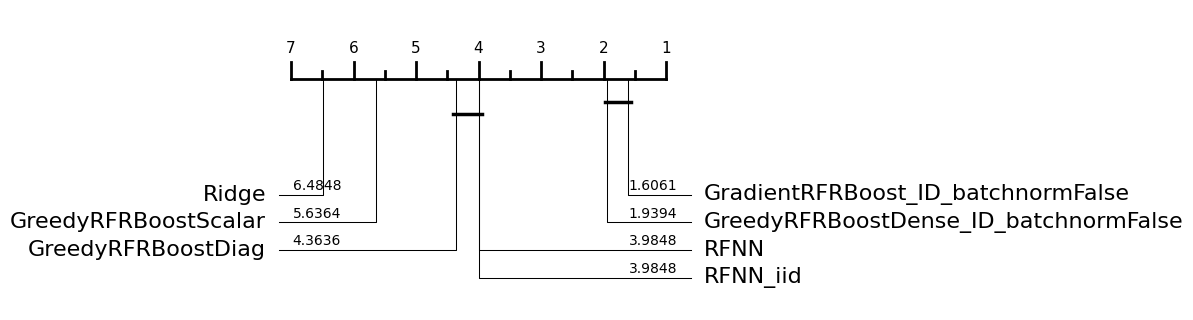

In [46]:
from aeon.visualisation import plot_critical_difference, plot_significance
import matplotlib.pyplot as plt

# Generate the plot
plot = plot_critical_difference(df["score_test"].values,
                                df["score_test"].columns.tolist(), 
                                alpha=0.05, 
                                lower_better=True)

# Retrieve the figure and axes from the plot
fig = plot[0].figure
ax = plot[0]

# Adjust figure size
fig.set_size_inches(6, 3)

# Adjust layout
fig.tight_layout()

# Save the figures
plot[0].savefig("results/OpenMLRegression/OpenMLReg_critical_difference.eps", bbox_inches='tight')
plot[0].savefig("results/OpenMLRegression/OpenMLReg_critical_difference.png", bbox_inches='tight')

In [ ]:
import pandas as pd
import numpy as np

def create_latex_table(df):
    table = """
\\begin{table}[t]
\\caption{Test accuracies on the concentric circles task.}
\\label{tab:concentric-circles}
\\vskip 0.15in
\\begin{center}
\\begin{small}
\\begin{sc}
\\begin{tabular}{lcc}
\\toprule
Model & Mean Acc & Std Dev \\\\
\\midrule
"""
    for model_name in df.columns:
        accs = df[model_name]
        mean_acc = np.mean(accs)
        std_acc = np.std(accs)
        table += f"{model_name} & {mean_acc:.4f} & {std_acc:.4f} \\\\\n"
    
    table += """
\\bottomrule
\\end{tabular}
\\end{sc}
\\end{small}
\\end{center}
\\vskip -0.1in
\\end{table}
"""
    return table

# Example usage
# Assuming `results_df` is your pandas DataFrame
latex_table = create_latex_table(df_old["score_test"])
print(latex_table)

In [44]:
# df2 = results_to_df(        
#     datasets = openML_reg_ids_noCat[[0,1,2  ,4,5,6,7,8,9,10,     13,14,15,16,17,18,19]],
#     save_dir = "/home/nikita/Code/random-feature-boosting/save/regv2_added40nlayers/OpenMLRegression/",
#     )

In [45]:
# df2["score_test"].mean().sort_values(ascending=True)

In [46]:
# df2["score_train"].mean().sort_values(ascending=True)

In [27]:
# df2["score_test"].rank(axis=1).mean().sort_values()

In [28]:
#number of first places
# (df2["score_test"].rank(axis=1) == 1).sum().sort_values()

In [29]:
# XGBoostRegressor       0.389427
# End2End                0.408184
# GreedyRFBoostDense      0.43249
# GradientRFBoost        0.434696
# GradientRFBoostID      0.436364
# GreedyRFBoostDiag      0.445675
# GreedyRFBoostScalar    0.528314
# Ridge                  0.606384
# RidgeCV                0.606385
# dtype: object


# XGBoostRegressor       0.170585
# End2End                0.345058
# GreedyRFBoostDense     0.387421
# GradientRFBoost        0.400575
# GradientRFBoostID      0.405132
# GreedyRFBoostDiag       0.41455
# GreedyRFBoostScalar    0.510962
# RidgeCV                0.600331
# Ridge                   0.60034
# dtype: object


# XGBoostRegressor       2.666667
# End2End                3.333333
# GreedyRFBoostDense     3.500000
# GradientRFBoost        3.611111
# GradientRFBoostID      4.111111
# GreedyRFBoostDiag      4.777778
# GreedyRFBoostScalar    6.722222
# Ridge                  8.055556
# RidgeCV                8.222222
# dtype: float64


# Ridge                   0
# RidgeCV                 0
# GradientRFBoostID       0
# GreedyRFBoostScalar     0
# GradientRFBoost         1
# GreedyRFBoostDense      1
# GreedyRFBoostDiag       1
# End2End                 4
# XGBoostRegressor       11
# dtype: int64

# Look at small datasets

In [ ]:
less5000 = df_metadata.query("n_obs < 5000").index
less1000 = df_metadata.query("n_obs < 1000").index
less5000

In [ ]:
df["score_test"].loc[less5000].mean().sort_values(ascending=True)

In [ ]:
df["score_test"].loc[less5000].rank(axis=1).mean().sort_values(ascending=True)

In [ ]:
df["score_test"].loc[less5000].rank(axis=1)

In [ ]:
df["score_test"].loc[less1000]

# Look at distribution of params

In [ ]:
import matplotlib.pyplot as plt

def plot_param_distribution(
        models = ["End2End", "Ridge", #"XGBoostRegressor", 
                  "GradientRFRBoost", 
                  #"GradientRFRBoostID", 
                  #"GradientRFRBoost_relu",
                  "GreedyRFRBoostDense", "GreedyRFRBoostDiag", "GreedyRFRBoostScalar",
                  #"GreedyRFRBoostDense_relu", "GreedyRFRBoostDiag_relu", "GreedyRFRBoostScalar_relu",
                  "RandomFeatureNetwork", 
                  #"RandomFeatureNetwork_iid",
                  #"RandomFeatureNetwork_relu", "RandomFeatureNetwork_iid_relu",
                  ],
        datasets = openML_reg_ids[:],
        save_dir = "/home/nikita/Code/random-feature-boosting/save/OpenMLRegression/",
        # save_dir = "/home/nikita/Code/random-feature-boosting/save/regv2_added40nlayers/OpenMLRegression/",
        ):
    # Load and join the JSON data
    results_json = get_joined_results_json(models, datasets, save_dir)

    # model: list_of_param_names
    modelwise_param_names = {model: list(results_json[str(datasets[0])][model]['hyperparams'][0])
                            for model in models} 

    # model: param_name: list_of_param_values
    param_distribution = { model: {param: [] for param in param_names}
                          for model, param_names in modelwise_param_names.items()}

    #populate teh param_districution nested dict
    for dataset, dataset_results in results_json.items():
        for model_name, model_results in dataset_results.items():
            for fold in model_results["hyperparams"]:
                for param_name, param_val in fold.items():
                    param_distribution[model_name][param_name].append(param_val)

    # For each model, plot the distribution of each parameter
    for model, param_dict in param_distribution.items():
        print(f"Model: {model}")
        for param_name, param_values in param_dict.items():
            if param_name not in [
                "out_dim", "loss", "objective", "feature_type",
                "upscale_type", "sandwich_solver"
                ]:
                # Create figure with two subplots side by side
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
                
                # Linear scale plot
                ax1.hist(param_values, bins=20)
                ax1.set_title(f"{model} {param_name}\n(linear scale)")
                ax1.set_xlabel(param_name)
                ax1.set_ylabel("Count")
                
                # Log scale plot
                min_val = np.min(param_values)  # Avoid log(0)
                max_val = np.max(param_values)
                bins = np.logspace(np.log10(min_val), np.log10(max_val), 20)
                ax2.hist(param_values, bins=bins)
                ax2.set_xscale('log')
                ax2.set_title(f"{model} {param_name}\n(log scale)")
                ax2.set_xlabel(param_name)
                ax2.set_ylabel("Count")
                
                plt.tight_layout()
                plt.show()

plot_param_distribution()